# Tweets

---
embed-resources: true
---

## Introduction

We are developing a model for use within the social media team of our airline. We aim to analyze recent tweets in order to determine how to automatically reply to them, either to a tweet expressing a positive, neutral, or negative sentiment.

## Methods

In [112]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier


### Data

In [113]:
# load data
tweets_train = pd.read_parquet(
    "https://cs307.org/lab/data/tweets-train.parquet",
)
tweets_test = pd.read_parquet(
    "https://cs307.org/lab/data/tweets-test.parquet",
)

# create X and y for train data
X_train = tweets_train["text"]
y_train = tweets_train["sentiment"]

# create X and y for test data
X_test = tweets_test["text"]
y_test = tweets_test["sentiment"]

Each observation in the dataset represents a single tweet from twitter. The data dictionary is detailed below.

### Response
**`sentiment`**
- [object] the sentiment of the tweet. One of negative, neutral, or positive.

### Features
**`text`**
- [object] the full text of the tweet.

### Additional Variables
**`airline`**
- [object] the airline the tweet was “sent” to.


In [114]:
# summary statistics
X_train.shape

(8235,)

The training dataset has 8,235 observations and 1 feature, the tweet.

In [115]:
pd.concat([tweets_train['airline'].value_counts(), tweets_train['airline'].value_counts(normalize=True)],axis=1)

,count,proportion
airline,,
United,2166,0.263024
US Airways,1664,0.202064
American,1551,0.188342
Southwest,1347,0.163570
Delta,1239,0.150455
Virgin America,268,0.032544


There is a decent amount of tweets from these six airlines, except Virgin America.

In [116]:
counter = CountVectorizer()
word_counts = counter.fit_transform(X_train).todense()

word_counts = pd.DataFrame(
    word_counts,
    columns=sorted(list(counter.vocabulary_.keys())),
)

pd.DataFrame(word_counts[['cancelled', 'please', 'thanks']].sum(), columns=['count'])

,count
cancelled,595
please,325
thanks,587


The word *cancelled* appears 595 times, *please* appears 325 times, and *thanks* 587 times. People say *thanks* more often than *please*, and about as much as *cancelled*.

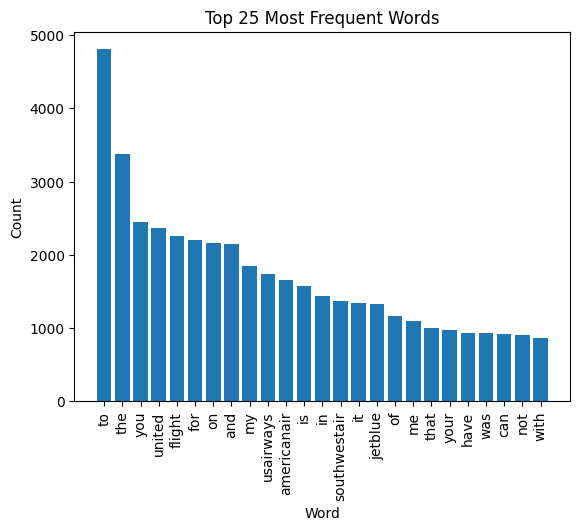

In [117]:
# | echo: False
# | lightbox: True
# exploratory visualization
top_25 = word_counts.sum().sort_values(ascending=False)[0:25]
plt.bar(top_25.index, top_25)
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Top 25 Most Frequent Words")
plt.show()

The most common words are just grammatical words and the names of the airlines.

### Models

In [ ]:
# train models
pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer(max_features=50)),
        ('estimator', RandomForestClassifier())
    ]
)

param_grid = [
    {
        "estimator": [RandomForestClassifier(n_estimators=50)],
    }
]

model = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5, refit=True, n_jobs=-1)
_ = model.fit(X_train, y_train)
model.best_params_

{'estimator': RandomForestClassifier(n_estimators=50)}

We vectorize the tweets with `TfidfVectorizer` and feed the resulting features into a random forest model.

## Results

In [125]:
# report model metrics
y_pred = model.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {score:.2%}")

Test Accuracy: 68.31%


In [122]:
# | echo: false
# | output: false
# serialize model
dump(model, 'tweets.joblib', compress=9)

['tweets.joblib']

## Discussion

I would recommend against putting this model into practice. The accuracy is only 68%, and the costs of mistaking sending an automated reply to a negative tweet misidentified as having a positive sentiment may worsen that sentiment and further alienate that customer. According to the graph below, most tweets were predicted as having a negative sentiment, so this would be the most likely way that our model messes up.

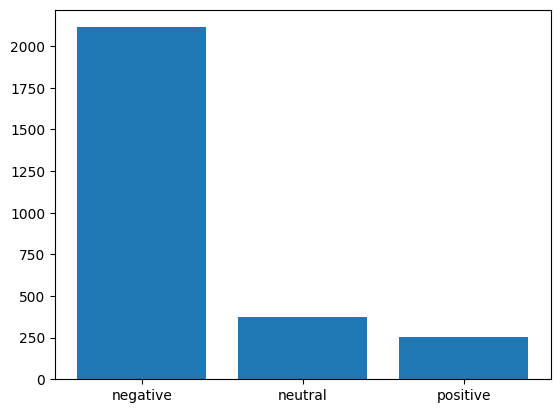

In [138]:
# | echo: false
# | lightbox: true
# summary figure
x = pd.DataFrame(y_pred, columns=['pred'])['pred'].value_counts()
plt.bar(x.index, x)
plt.show()